C:\Users\Steve\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


17682/17682 ━━━━━━━━━━━━━━━━━━━━ 5s 283us/step


C:\Users\Steve\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Steve\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


ANN pred stats: -7.7171116 1713.7443 79.07099
17682/17682 ━━━━━━━━━━━━━━━━━━━━ 7s 401us/step


C:\Users\Steve\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


CNN pred stats: -9.51735 1695.5841 76.1013


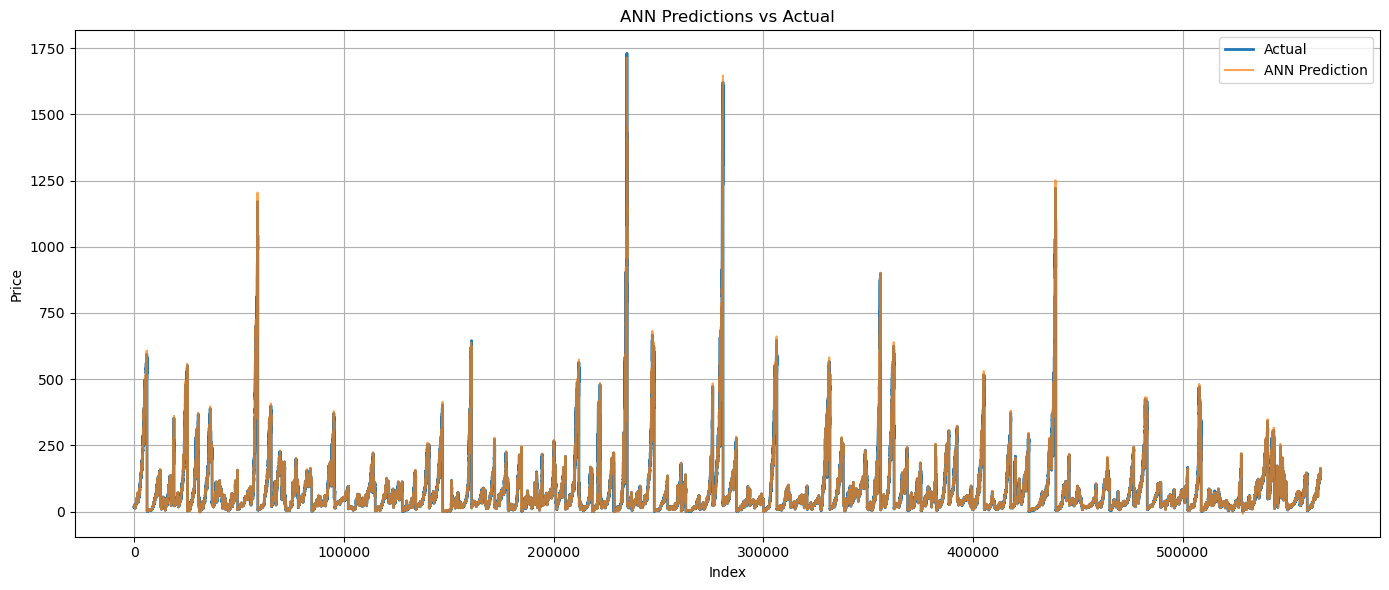

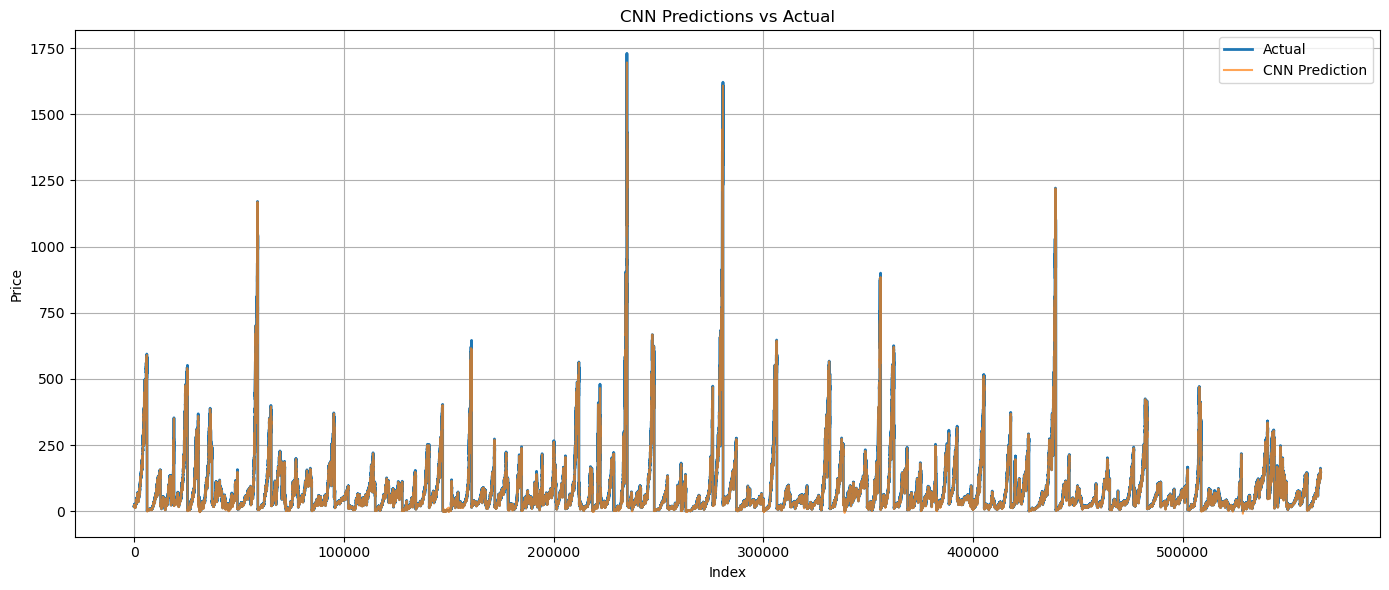

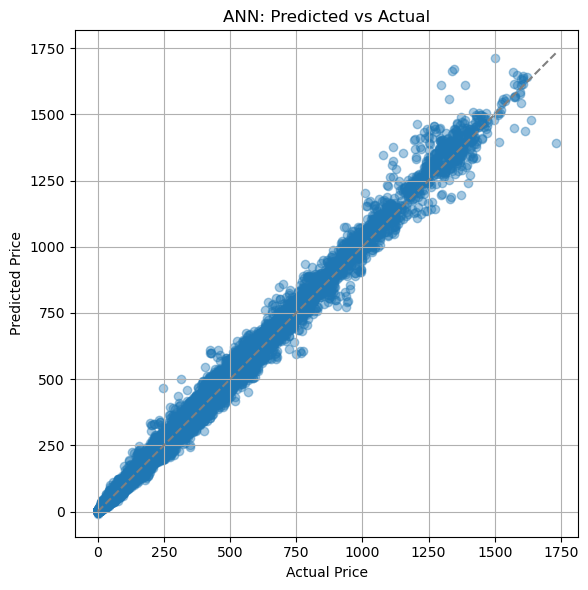

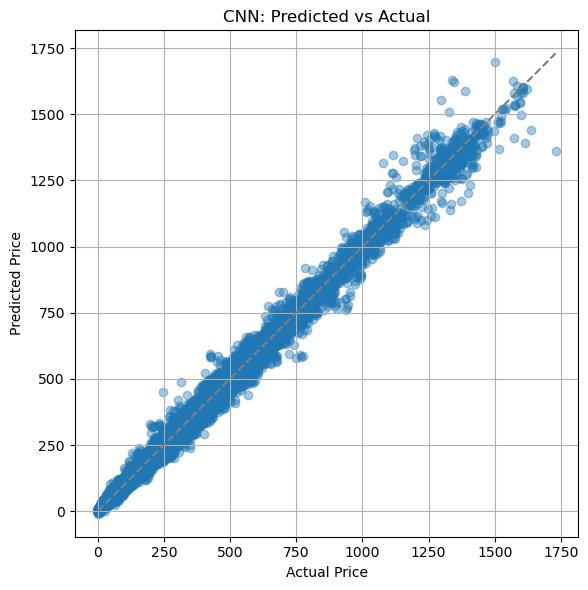


ANN: RMSE = 6.36
ANN: R2 Score = 0.9965
ANN: MAE = 2.76

CNN: RMSE = 6.19
CNN: R2 Score = 0.9967
CNN: MAE = 3.10


In [1]:
#ECGR-4105 ANN and CNN Ai Stock Predictor
#Steve Revens
#Harrison Hall

import yfinance as yf
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, InputLayer

# Debugging help
NUM_COMPANIES = 500                   # Set to 500 for full run
FORCE_REDOWNLOAD = True               # Set to False if the spreadsheets are downloaded and current, stops the program from re-downloading the spreadsheets
SAVE_DIR = "data"
FUNDAMENTAL_DIR = "fundamentals"

# Get S&P tickers
def get_sp500_tickers():
    url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
    df = pd.read_csv(url)
    return df['Symbol'].str.replace('.', '-', regex=False).tolist()

# Download the data
def download_stock_data(tickers, start="2000-01-01", end=None, save_dir=SAVE_DIR, force_redownload=False):
    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(FUNDAMENTAL_DIR, exist_ok=True)
    data = {}
    for i, ticker in enumerate(tickers):
        file_path = os.path.join(save_dir, f"{ticker}.csv")
        fundamentals_path = os.path.join(FUNDAMENTAL_DIR, f"{ticker}_fundamentals.csv")
        try:
            stock = yf.Ticker(ticker)
            if os.path.exists(file_path) and not force_redownload:
                print(f"Reading cached data for {ticker}")
                df = pd.read_csv(file_path)
                if 'Date' not in df.columns or 'Close' not in df.columns:
                    continue
                df['Date'] = pd.to_datetime(df['Date'])
                df.set_index('Date', inplace=True)
            else:
                print(f"Downloading {ticker} ({i+1}/{len(tickers)})")
                df = stock.history(start=start, end=end, auto_adjust=False)
                if df.empty or len(df) < 200:
                    continue
                df.reset_index(inplace=True)
                df.to_csv(file_path, index=False)
                df.set_index('Date', inplace=True)
            info = stock.info
            new_row = {
                'Date': datetime.today().strftime("%Y-%m-%d"),
                'Ticker': ticker,
                'peRatio': info.get('trailingPE', 0.0),
                'pegRatio': info.get('pegRatio', 0.0),
                'priceToSales': info.get('priceToSalesTrailing12Months', 0.0),
                'priceToBook': info.get('priceToBook', 0.0),
                'debtToEquity': info.get('debtToEquity', 0.0),
                'ebitda': info.get('ebitda', 0.0)
            }
            if os.path.exists(fundamentals_path):
                existing = pd.read_csv(fundamentals_path)
                if not ((existing['Date'] == new_row['Date']) & (existing['Ticker'] == new_row['Ticker'])).any():
                    updated = pd.concat([existing, pd.DataFrame([new_row])], ignore_index=True)
                    updated.to_csv(fundamentals_path, index=False)
            else:
                pd.DataFrame([new_row]).to_csv(fundamentals_path, index=False)
            df['Ticker'] = ticker
            data[ticker] = df
            time.sleep(0.2)
        except Exception as e:
            print(f"Error with {ticker}: {e}")
    return data

# Preprocess for training
def preprocess_data(data):
    frames = []
    for ticker, df in data.items():
        try:
            if 'Close' not in df.columns:
                continue
            df = df[['Open', 'High', 'Low', 'Volume', 'Close']].copy()
            df['Lag_Close'] = df['Close'].shift(1)
            df['MA_5'] = df['Close'].rolling(5).mean()
            df['Return'] = df['Close'].pct_change()
            df['Target'] = df['Close'].shift(-5)
            df.dropna(inplace=True)
            if len(df) < 10:
                continue
            fund_file = os.path.join(FUNDAMENTAL_DIR, f"{ticker}_fundamentals.csv")
            if not os.path.exists(fund_file):
                continue
            row = pd.read_csv(fund_file).sort_values('Date').iloc[-1]
            for col in ['peRatio', 'pegRatio', 'priceToSales', 'priceToBook', 'debtToEquity', 'ebitda']:
                value = row.get(col, 0.0)
                df[col] = value if not pd.isna(value) else 0.0
            df['Ticker'] = ticker
            frames.append(df)
        except Exception as e:
            print(f"Preprocessing error on {ticker}: {e}")
    if not frames:
        raise ValueError("All tickers failed during preprocessing.")
    result = pd.concat(frames)
    result.reset_index(inplace=True)
    return result.dropna()

# Extract features and labels
def prepare_features(df):
    y = df['Target']
    X = df.drop(columns=['Target'])
    non_numeric_cols = X.select_dtypes(include=['object', 'datetime64']).columns.tolist()
    for col in ['Date', 'Datetime']:
        if col in X.columns:
            non_numeric_cols.append(col)
    X.drop(columns=list(set(non_numeric_cols)), inplace=True)
    le = LabelEncoder()
    if 'Ticker' in df.columns:
        X['Ticker'] = le.fit_transform(df['Ticker'])
    if y.nunique() <= 1:
        raise ValueError("Target values have no variation.")
    return X, y

# Train and evaluate ANN
def build_ann(input_dim):
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train and evaluate CNN
def build_cnn(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_ann_cnn(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=False, test_size=0.2)

    ann = build_ann(X_train.shape[1])
    ann.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0)
    ann_preds = ann.predict(X_test).flatten()
    y_test_np = np.array(y_test)
    ann_mask = ~np.isnan(ann_preds) & ~np.isnan(y_test_np)
    ann_preds = ann_preds[ann_mask]
    ann_clean = y_test_np[ann_mask]
    ann_rmse = mean_squared_error(ann_clean, ann_preds, squared=False)
    ann_r2 = r2_score(ann_clean, ann_preds)
    print("ANN pred stats:", np.min(ann_preds), np.max(ann_preds), np.mean(ann_preds))

    X_cnn_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_cnn_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    cnn = build_cnn((X_cnn_train.shape[1], 1))
    cnn.fit(X_cnn_train, y_train, epochs=30, batch_size=64, verbose=0)
    cnn_preds = cnn.predict(X_cnn_test).flatten()
    mask = ~np.isnan(cnn_preds) & ~np.isnan(y_test_np)
    cnn_preds = cnn_preds[mask]
    y_clean = y_test_np[mask]
    if len(y_clean) == 0:
        cnn_rmse = np.nan
        cnn_r2 = np.nan
        print("CNN predictions invalid: all values filtered out.")
    else:
        cnn_rmse = mean_squared_error(y_clean, cnn_preds, squared=False)
        cnn_r2 = r2_score(y_clean, cnn_preds)
        print("CNN pred stats:", np.min(cnn_preds), np.max(cnn_preds), np.mean(cnn_preds))

    return ann_clean, ann_preds, y_clean, cnn_preds, ann_rmse, ann_r2, cnn_rmse, cnn_r2

    # Plot
def plot_predictions(y_true_ann, ann_preds, y_true_cnn, cnn_preds):
    if len(y_true_ann) == len(ann_preds):
        plt.figure(figsize=(14, 6))
        plt.plot(y_true_ann, label='Actual', linewidth=2)
        plt.plot(ann_preds, label='ANN Prediction', alpha=0.7)
        plt.title("ANN Predictions vs Actual")
        plt.xlabel("Index")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping ANN plot: mismatched lengths.")

    if len(y_true_cnn) == len(cnn_preds) and len(y_true_cnn) > 0:
        plt.figure(figsize=(14, 6))
        plt.plot(y_true_cnn, label='Actual', linewidth=2)
        plt.plot(cnn_preds, label='CNN Prediction', alpha=0.7)
        plt.title("CNN Predictions vs Actual")
        plt.xlabel("Index")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping CNN plot: predictions invalid or empty.")

def plot_scatter(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='gray')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Main
tickers = get_sp500_tickers()[:NUM_COMPANIES]
stock_data = download_stock_data(tickers, force_redownload=FORCE_REDOWNLOAD)
processed = preprocess_data(stock_data)
X, y = prepare_features(processed)
ann_clean, ann_pred, y_clean, cnn_pred, ann_rmse, ann_r2, cnn_rmse, cnn_r2 = train_ann_cnn(X, y)
plot_predictions(ann_clean, ann_pred, y_clean, cnn_pred)
plot_scatter(ann_clean, ann_pred, model_name="ANN")
plot_scatter(y_clean, cnn_pred, model_name="CNN")

print(f"\nANN: RMSE = {ann_rmse:.2f}")
print(f"ANN: R2 Score = {ann_r2:.4f}")
print(f"ANN: MAE = {mean_absolute_error(ann_clean, ann_pred):.2f}")
print(f"\nCNN: RMSE = {cnn_rmse:.2f}")
print(f"CNN: R2 Score = {cnn_r2:.4f}")
print(f"CNN: MAE = {mean_absolute_error(y_clean, cnn_pred):.2f}")



